# THƯ VIỆN CẦN THIẾT

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# PHÂN TÍCH DỮ LIỆU
- [INSERT MÔ TẢ SƠ BỘ VỀ 3 FILE/CÁC CÂU HỎI/CÁC BƯỚC LÀM]

## I. TIỀN XỬ LÝ DỮ LIỆU
### Dữ liệu có bao nhiêu dòng, bao nhiêu cột?

In [28]:
df_playlist = pd.read_csv("data/playlist.csv")
df_track    = pd.read_csv("data/track.csv")
df_user     = pd.read_csv("data/user.csv")

df_playlist.shape, df_track.shape, df_user.shape

((6777, 6), (46544, 11), (22161, 7))

### Các file dữ liệu có các dòng nào bị trùng lắp hoàn toàn không?
- Thấy rằng từ output, không có dòng nào bị trùng lắp hoàn toàn trong từng file dữ liệu

In [29]:
df_playlist.duplicated().sum(), df_track.duplicated().sum(), df_user.duplicated().sum()

(0, 0, 0)

### Mỗi cột thuộc kiểu dữ liệu nào? Có cột nào bị thiếu dữ liệu không?
- Với mỗi file, kết hợp 2 công việc này vào 1 dataframe. Dataframe này gồm các cột chính là các cột thuộc tính trong lần lượt 3 file x 2 hàng có tên: 
    - `DataType` - thể hiện kiểu dữ liệu của các thuộc tính trong file
    - `NaN counts` - đếm số lượng dữ liệu thiếu tại mỗi cột  
- Theo đồ án 1, ý nghĩa của mỗi thuộc tính trong mỗi file như sau:
    - `playlist.csv`:
        - `id`: mã của playlist đó, mã này dùng để phân biệt với các playlist khác, mỗi playlist sẽ có một mã số `id` duy nhất.
        - `name`: là tên của playlist đó (trong trường hợp playlist đó không có tên thì ta gán `name` là `null`).
        - `genre`: là thể loại của playlist đó (trong trường hợp playlist đó chưa được đặt thể loại thì ta gán `genre` là `null`).
        - `likes_count`: tổng số lượt likes của playlist
        - `track_ids`: là chuỗi gồm danh sách các track có track_id nằm trong playlist đó.
    - `track.csv`:
        - `id`: id của track. Lưu ý 1 track có thể nằm trong nhiều playlist
        - `name`: tên track
        - `genre`: thể loại track
        - `playlist_id`: playlist_id mà track có mã là `id` thuộc về
        - `author_id`: mỗi track có 1 user có mã đại diện là `author_id` phụ trách
        - `likes_count`: tổng số lượt likes của track
        - `playback_count`: tổng số lượt replay của track
        - `download_count`: tổng số lượt tải về track đó
        - `created_date`: ngày track đó được tạo
    - `user.csv`:
        - `id`: mã người dùng, là duy nhất. Lưu ý 1 người dùng có thể phụ trách 1 hoặc nhiều track
        - `full_name`: họ và tên user
        - `username`: tên tài khoản user
        - `track_id`: track mà user 
        - `followers_count`: số lượng người theo dõi user đó

In [30]:
pd.DataFrame([df_playlist.dtypes, (df_playlist.isna().sum()/df_playlist.shape[0]*100).round(2)], index= ['type', 'missing percentage'])

,playlist_id,playlist_name,genre,likes_count,reposts_count,track_ids
type,int64,object,object,int64,int64,object
missing percentage,0.0,0.0,82.22,0.0,0.0,0.97


In [31]:
pd.DataFrame([df_track.dtypes, (df_track.isna().sum()/df_track.shape[0]*100).round(2)], index= ['type', 'missing percentage'])

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date
type,int64,object,object,int64,int64,float64,float64,float64,int64,float64,object
missing percentage,0.0,0.0,14.41,0.0,0.0,1.84,1.84,1.84,0.0,2.11,0.0


In [32]:
pd.DataFrame([df_user.dtypes, (df_user.isna().sum()/df_user.shape[0]*100).round(2)], index= ['type', 'missing percentage'])

,user_id,full_name,username,followers_count,track_count,country_code,verified
type,int64,object,object,int64,int64,object,bool
missing percentage,0.0,38.55,0.0,0.0,0.0,41.69,0.0


### Xử lý dòng bị thiếu dữ liệu 

### a) Loại dòng thiếu dữ liệu

-  File `playlist.csv`: từ mô tả thuộc tính và kiểu dữ liệu của `track_ids`, thì cần loại đi các playlist không có track nào (tức thuộc tính `track_ids` bị thiếu). Ngoài ra, cũng có 2706 dòng bị thiếu thuộc tính `genre` nhưng qua quan sát sơ bộ file `playlist.csv`, hầu hết tên các playlist (`playlist_name`) sẽ được đặt theo tên thể loại nhạc nên ta sẽ không xóa các dòng thiếu thuộc tính `genre`

In [33]:
df_playlist = df_playlist.dropna(subset=['track_ids'])
df_playlist.shape

(6711, 6)

- File `track.csv`: tương tự với cách giải thích của `playlist.csv`, ta sẽ không xóa các dòng thiếu thuộc tính `track_genre`. Tuy nhiên sẽ xóa các dòng thiếu thuộc tính likes_count, playback_count, download_count vì đây là các thuộc tính numeric quan trọng cho bước khám phá dữ liệu sau này

In [34]:
df_track = df_track.dropna(subset= ['track_genre', 'likes_count', 'playback_count', 'download_count', 'comment_count'])
df_track.shape

(39060, 11)

- File `user.csv`: không xóa dòng nào vì tuy các user có thể không có tên `full_name` nhưng ta vẫn có thể thao tác với dataframe df_user dựa vào định danh của user đó (tức `user_id`) 

### b) Thay thế giá trị thiếu thành 1 giá trị khác

- Trong file `playlist.csv`, do cột genre bị thiếu khá nhiều (2706/3372) nên ta không loại các dòng thiếu genre được vì sẽ không đủ dữ liệu. Ngoài ra, có 2 vấn đề phát sinh 
    - _Vấn đề 1_: cột `genre` bị thiếu khá nhiều (2706/3372) nên ta không loại các dòng thiếu `genre` được vì sẽ không đủ dữ liệu để phân tích sau này 
    <br>=> Giải pháp: nội suy từ cột `playlist_name`. Từ quan sát file, thấy rằng hầu hết tên playlist có xu hướng thể hiện luôn thể loại của playlist đó. VD: `playlist_name` = *"Hip Hop Supreme"* thì có thể nội suy được thể loại là **hiphop**
    - _Vấn đề 2_: từ vấn đề 1, thấy rằng ở các playlist thiếu thuộc tính `genre` có thể mang nhiều thể loại. VD: `playlist_name` = *"| Chill | Lofi | Hip Hop |"* thì playlist đó có tới 3 thể loại: **[chill, lofi, hiphop]**. Ngoài ra, kể cả khi playlist có thuộc tính `genre` (VD: `genre` = *"LoFi hip hop"*) thì thấy rằng playlist vẫn có thể mang thuộc về nhiều thể loại
    <br>=> Giải pháp: ta cần phân rã (pd.explode()) cột `genre` phòng trường hợp 1 playlist thuộc nhiều thể loại
    - _Vấn đề 3_: giả sử giải quyết được 2 vấn đề trên thì thấy rằng tên thể loại vẫn chưa đồng nhất (VD: `genre` = *"Blue's_Music"* và `genre` = *"blues"*)
    <br>=> Giải pháp: cần 1 file `keywords.txt` để lưu cứng tên của các thể loại nhạc sẽ xuất hiện trong chuỗi string `genre` (file này được lấy từ project 1 và được tinh chỉnh lại để phù hợp). Ta sẽ chuẩn hóa thể loại dựa vào file này: xét chuỗi thể loại (VD: `genre` = *"Hip-hop & Rap"*), nếu chuỗi thể loại này chứa bất kỳ chuỗi con trong `keywords.txt` (VD: *"hiphop"* và *"rap"*) thì thể loại sẽ được thay bằng (tập) chuỗi con ấy (VD: `genre` sau khi chuẩn hóa = *["hiphop", "rap"]*)
- Kết hợp cả 3 giải pháp trên, ta được cách xử lý sau: 
    - Cộng 2 cột 'playlist_name' & 'genre', nếu 'genre' là NaN thì coi như chuỗi rỗng, kết quả cộng chuỗi lưu vào `df_playlist['genre']`
    - Chuẩn hóa `name_genre` theo giải pháp 3, kết quả sau khi chuẩn hóa là 1 list, lưu lại vào `name_genre`. Sau khi chuẩn hóa có thể vẫn tồn tại NaN nhưng ít hơn (NaN tồn tại là vì cột `playlist_name` không chứa thể loại nhạc nào nên không nội suy được + cột `genre` bị rỗng). Tiến hành bỏ đi các dòng chứa NaN này


In [35]:
with open('data/keywords.txt', encoding= 'utf-8') as f:
    keywords = f.readlines()
keywords = [item.strip('\n').strip(' ') for item in keywords]

In [36]:
# namegenre = playlist_name + playlist_genre
name_genre = df_playlist.apply(lambda row: row['playlist_name'] if pd.isna(row['genre']) else row['playlist_name'] + row['genre'], axis = 1)
name_genre

0               Best Rap Right Now: Drippin'Hip-hop & Rap
1                                         Hip Hop Supreme
2                        Lowfi hip hop chillsLofi Hip Hop
3            Hip-Hop Party Starters: Turn UpHip-hop & Rap
4                         Study & Chill | Lofi HiphopLofi
                              ...                        
6772                                       Southeast Asia
6773                                                   og
6774                     Understanding Southeast AsiaAsia
6775                                                 King
6776    Thacity314... Hoodwi$e MidWe$t CityBoi & $outh...
Length: 6711, dtype: object

In [37]:
def list_genres(genre_str, keywords=keywords):
    res = []

    for keyword in keywords:
        if keyword in genre_str:
            res.append(keyword)

    return res

# UNBLOCK THIS LINE !!!!
df_playlist['genre'] = name_genre.apply(lambda val: list_genres(re.sub(r'(hip-hop|hip hop)', 'hiphop', val.lower())))
#-----------------------
# print("Sau khi bỏ 513 giá trị NaN cột genre:")
# df_playlist = df_playlist.explode('genre').dropna()

df_playlist = df_playlist.loc[df_playlist['genre'].astype(bool)] # loại các phần tử empty list ở cột genre
df_playlist

,playlist_id,playlist_name,genre,likes_count,reposts_count,track_ids
0,730118454,Best Rap Right Now: Drippin',"[hiphop, rap]",389440,21590,"1175290570,1163320396,1150594213,1126802848,11..."
1,380154338,Hip Hop Supreme,[hiphop],178872,9795,"594112890,596212962,593601912,597082389,597563..."
2,306226961,Lowfi hip hop chills,"[hiphop, chill, lofi]",203955,20706,"216774635,406234053,755194606,266707458,670884..."
3,730129140,Hip-Hop Party Starters: Turn Up,"[hiphop, rap]",106087,4498,"1174777750,1118019910,1052667649,1099546222,11..."
4,595582668,Study & Chill | Lofi Hiphop,"[hiphop, chill, lofi]",95519,5951,"483466125,434763492,473421939,194708585,754271..."
...,...,...,...,...,...,...
6767,263799012,Sampler - Brokenhearted Dragonflies - Insect E...,"[electro, electronic, asia]",2,0,285573280
6769,590610360,South Asia,[asia],1,0,"214052731,278567119,421548432,269791621,421570..."
6770,116685376,Folk SouthAsia,"[folk, asia]",2,0,"141149534,4960240,164014742,73049766,86319632,..."
6772,874102157,Southeast Asia,[asia],0,0,"645192084,301217399,445266303,497328030,243885..."


- Trong file `track.csv`, ta cũng đổi thể loại nhạc về thể loại nhạc được định nghĩa trong file keywords.txt 

In [38]:
# redefine function
def list_genres(genre_str, keywords=keywords):
    res = []

    for keyword in keywords:
        if keyword in genre_str:
            res.append(keyword)
    # if not res:
    #     res = genre_str.split('&')
    return res

df_track['track_genre'] = df_track['track_genre'].apply(lambda val: list_genres(re.sub(r'[\-\.\/ ]', '', val.lower())))
df_track = df_track.loc[df_track['track_genre'].astype(bool)]
df_track
# ----------------------
# df_track = df_track.explode('track_genre')
# df_track = df_track.drop(df_track[df_track['track_genre'] == ''].index)
# df_track.head()

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date
0,1157194048,Polo G - Bad Man (Smooth Criminal),[hiphop],730118454,454955073,104933.0,3656798.0,0.0,1484,2949.0,2021-11-10T00:16:07Z
1,1134572425,"Who Want Smoke?? (feat. G Herbo, Lil Durk & 21...",[hiphop],730118454,811818505,229321.0,11713134.0,0.0,2994,7358.0,2021-10-01T21:15:32Z
2,1126802848,Rocc Climbing (feat. Lil Yachty),"[hiphop, rap]",730118454,277094000,191418.0,8635832.0,0.0,9338,3428.0,2021-09-18T08:16:48Z
3,1163320396,By Your Side,[rap],730118454,29550459,84417.0,2861345.0,0.0,952,1064.0,2021-11-19T21:15:58Z
4,1150594213,Super Gremlin,"[hiphop, rap]",730118454,72181005,180822.0,6808317.0,0.0,1826,2265.0,2021-10-30T03:48:49Z
...,...,...,...,...,...,...,...,...,...,...,...
46522,261051695,Banteay Srei - Citadel of the Women (1988),[chamber],233996745,218200669,1.0,299.0,0.0,0,0.0,2016-04-26T21:33:01Z
46529,152589690,Bob Marley - Jammin' (Kungs Remix),[reggae],212787729,54506965,183990.0,12199703.0,0.0,26231,1319.0,2014-06-03T10:31:50Z
46530,201306263,Deep Blues,[house],212787729,1409319,582.0,30312.0,0.0,78,6.0,2015-04-17T21:10:11Z
46534,337861748,I Get the Bag (feat. Migos),"[hiphop, rap]",507929004,2982659,996226.0,86553052.0,0.0,43788,5483.0,2017-08-14T18:45:12Z


### Chuyển đổi kiểu dữ liệu cho phù hợp


- File `playlist.csv`: từ mô tả thuộc tính và kiểu dữ liệu của `track_ids`, thì cần đổi kiểu dữ liệu của thuộc tính `track_ids` từ **string** sang dạng **list các số nguyên**

In [39]:
df_playlist['track_ids'] = df_playlist['track_ids'].apply(lambda x: [int(item) for item in x.split(',')])

- File `track.csv`: 
    - Cần đổi kiểu dữ liệu của 2 cột `likes_count`, `playback_count`từ **float** sang **int**
    - Cần đổi kiểu dữ liệu của `created_date` sang kiểu **datetime**

In [40]:
df_track[['likes_count', 'playback_count', 'download_count', 'comment_count']] = df_track[['likes_count', 'playback_count', 'download_count', 'comment_count']].astype(int)
df_track['created_date'] = pd.to_datetime(df_track['created_date'])
# df_track[['likes_count', 'playback_count', 'download_count', 'created_date']].head()

# II. KHÁM PHÁ DỮ LIỆU

## 1. Thể loại phổ biến/được yêu thích/được nghe nhiều/được tương tác nhiều nhất trong năm 2020

**Mục đích:** Trả lời được câu hỏi này giúp ta biết được xu hướng âm nhạc trong năm 2020.

**Các bước thực hiện:**
- Xác định các tracks được đăng vào năm 2020 (kết quả lưu vào `df_track_2020`)
- Thống kê phần trăm số track, like, playback và comment của từng thể loại (kết quả lưu vào `df_track_genre_stat`)
 - Tỉ lệ số track của một thể loại là tỉ lệ so với tổng số track tìm được và ứng với độ phổ biến của thể loại đó
 - Tỉ lệ số like của một thể loại là tỉ lệ so với tổng số like của các track tìm được và ứng với độ yêu thích của thể loại đó
 - Tỉ lệ số lượt playback của một thể loại là tỉ lệ so với tổng số lượt playback của các track tìm được và ứng với số lượt nghe của thể loại đó
 - Tỉ lệ số comment của một thể loại là tỉ lệ so với tổng số comment của các track tìm được ứng với độ tương tác của người dùng với các track thuộc thể loại đó
- Vẽ biểu đồ cột và nhận xét

In [42]:
def is_created_in_2020(track):
    return track['created_date'].year == 2020

df_track_2020 = df_track.loc[df_track.apply(is_created_in_2020, axis = 1)]
df_track_2020.head()

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date
32,755194606,take your time w/ Gavin Stacey,[chill],306226961,173815195,352,60196,0,19,9,2020-02-05 00:15:08+00:00
39,869432971,my block,"[hiphop, lofi]",306226961,173815195,180,19939,0,3,6,2020-08-03 15:19:31+00:00
112,870653725,Rags to Riches 2 (feat. Lil Baby),"[hiphop, rap]",740178957,29550459,274332,18337445,0,4478,14865,2020-08-05 15:54:16+00:00
113,899299963,Zelda's Lullaby,"[hiphop, rap]",740178957,3610679,5765,334691,0,236,315,2020-09-25 08:35:54+00:00
114,773936224,Smoke N Fuck,"[hiphop, rap]",740178957,53644751,7215,356840,0,150,187,2020-03-10 21:14:01+00:00


### Bước 1: Xác định các track được đăng vào năm 2020

In [44]:
def is_created_in_2020(track):
    return track['created_date'].year == 2020

df_track_2020 = df_track.loc[df_track.apply(is_created_in_2020, axis = 1)]
df_track_2020 = df_track.explode('track_genre')
df_track_2020.head()

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date
0,1157194048,Polo G - Bad Man (Smooth Criminal),hiphop,730118454,454955073,104933,3656798,0,1484,2949,2021-11-10 00:16:07+00:00
1,1134572425,"Who Want Smoke?? (feat. G Herbo, Lil Durk & 21...",hiphop,730118454,811818505,229321,11713134,0,2994,7358,2021-10-01 21:15:32+00:00
2,1126802848,Rocc Climbing (feat. Lil Yachty),hiphop,730118454,277094000,191418,8635832,0,9338,3428,2021-09-18 08:16:48+00:00
2,1126802848,Rocc Climbing (feat. Lil Yachty),rap,730118454,277094000,191418,8635832,0,9338,3428,2021-09-18 08:16:48+00:00
3,1163320396,By Your Side,rap,730118454,29550459,84417,2861345,0,952,1064,2021-11-19 21:15:58+00:00


### Bước 2: Thống kê phần trăm số track, like, playback và comment của từng thể loại

In [45]:
total_tracks_count = len(df_track_2020['track_id'].unique())
tracks_count = df_track_2020['track_genre'].value_counts()
tracks_percentage = tracks_count.apply(lambda x: x * 100.0 / total_tracks_count)
tracks_percentage = tracks_percentage.radd(pd.Series(dict(zip(keywords, [0 for keyword in keywords]))), fill_value = 0)

total_likes_count = df_track_2020.groupby(['track_id'])['likes_count'].max().sum()
likes_count = df_track_2020.groupby(['track_genre'])['likes_count'].sum()
likes_percentage = likes_count.apply(lambda x: x * 100.0 / total_likes_count)
likes_percentage = likes_percentage.radd(pd.Series(dict(zip(keywords, [0 for keyword in keywords]))), fill_value = 0)

total_playback_count = df_track_2020.groupby(['track_id'])['playback_count'].max().sum()
playback_count = df_track_2020.groupby(['track_genre'])['playback_count'].sum()
playback_percentage = playback_count.apply(lambda x: x * 100.0 / total_playback_count)
playback_percentage = playback_percentage.radd(pd.Series(dict(zip(keywords, [0 for keyword in keywords]))), fill_value = 0)

total_comment_count = df_track_2020.groupby(['track_id'])['comment_count'].max().sum()
comment_count  = df_track_2020.groupby(['track_genre'])['comment_count'].sum()
comment_percentage = comment_count.apply(lambda x: x * 100.0 / total_comment_count)
comment_percentage = comment_percentage.radd(pd.Series(dict(zip(keywords, [0 for keyword in keywords]))), fill_value = 0)

df_track_genre_stat = pd.DataFrame([pd.Series({'tracks_percentage':tracks_percentage[genre], 'likes_percentage':likes_percentage[genre], 'playback_percentage':playback_percentage[genre], 'comment_percentage':comment_percentage[genre]}) for genre in keywords], index = keywords)
df_track_genre_stat.head()

,tracks_percentage,likes_percentage,playback_percentage,comment_percentage
hiphop,10.269533,65.877658,73.421690,69.414805
chill,1.038163,0.727581,0.704230,0.732572
anime,0.623873,0.203463,0.348943,0.501305
blue,1.832627,0.442466,0.414822,0.225840
children,0.731101,0.007920,0.007214,0.177815


### Bước 3: Vẽ biểu đồ và nhận xét

<BarContainer object of 50 artists>

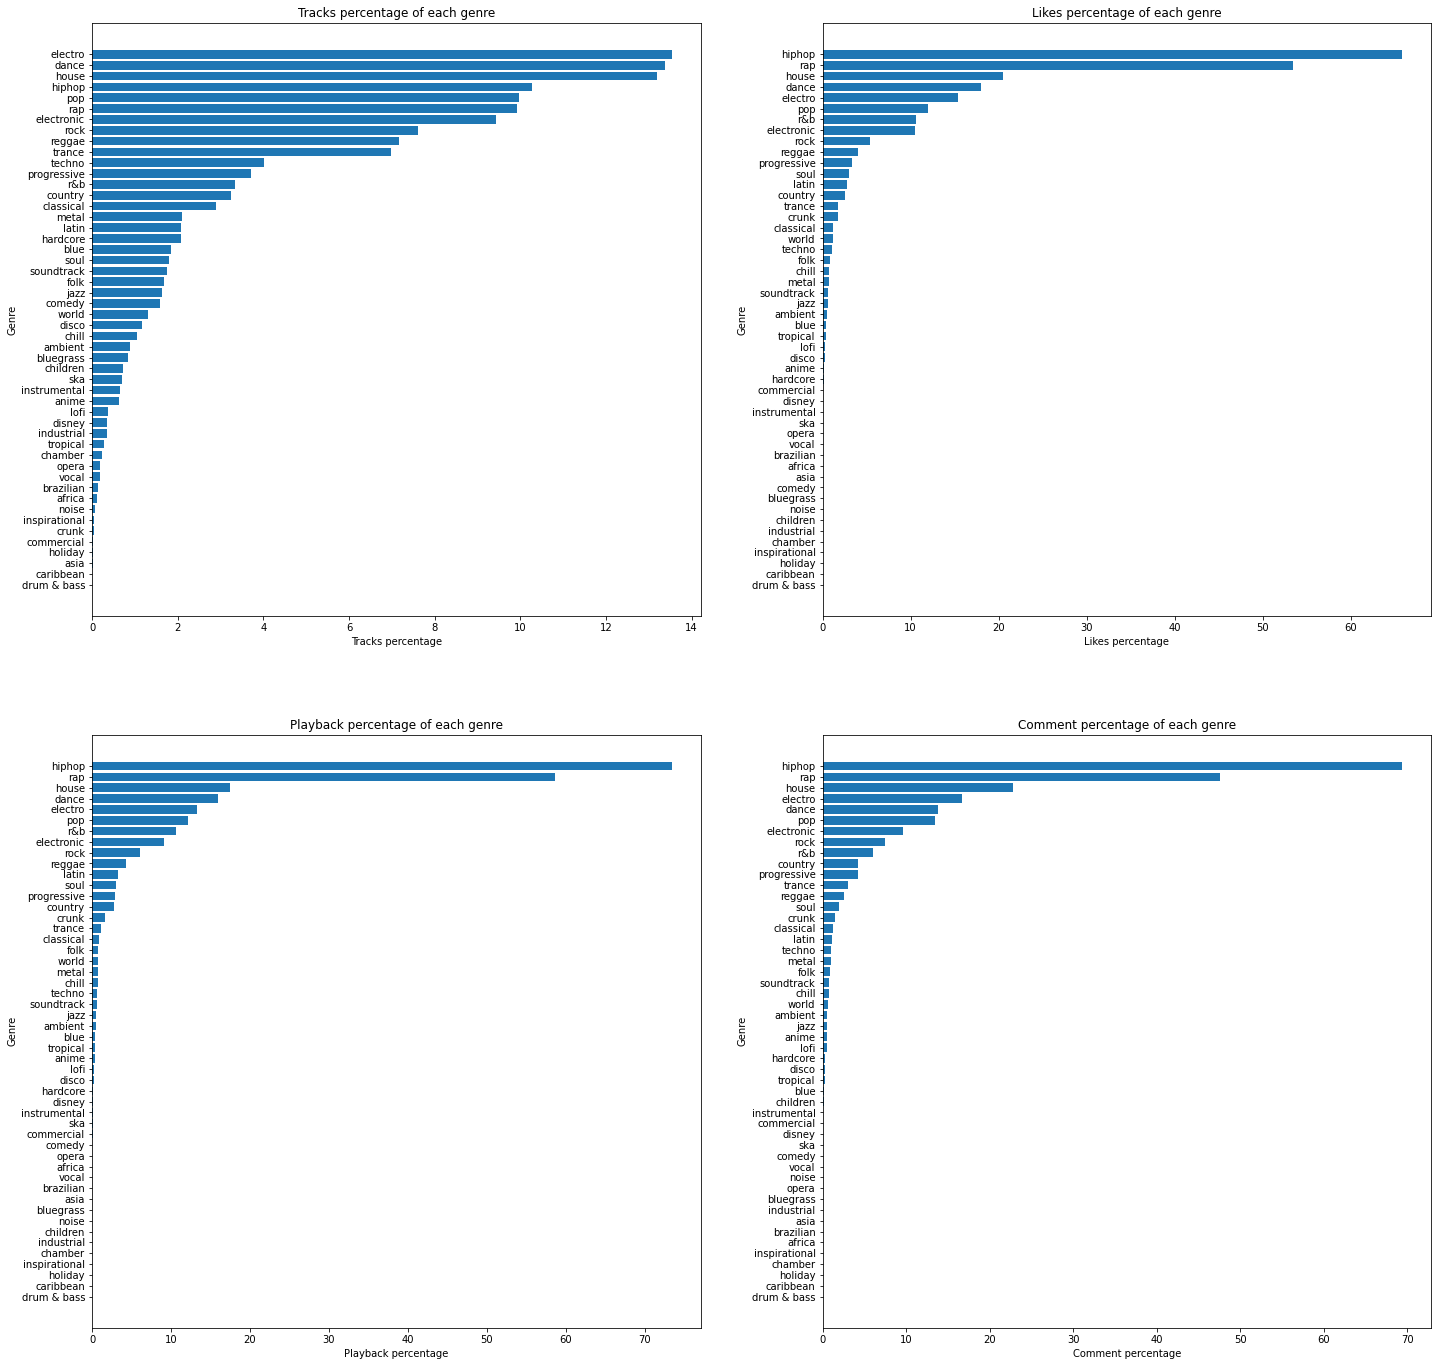

In [46]:
fig, axs = plt.subplots(2, 2, figsize = (24, 24))

df_track_genre_stat = df_track_genre_stat.sort_values('tracks_percentage', ascending = False)
axs[0, 0].set_title('Tracks percentage of each genre')
axs[0, 0].set(xlabel = 'Tracks percentage', ylabel = 'Genre')
axs[0, 0].invert_yaxis()
axs[0, 0].barh(df_track_genre_stat.index, df_track_genre_stat['tracks_percentage'])

df_track_genre_stat = df_track_genre_stat.sort_values('likes_percentage', ascending = False)
axs[0, 1].set_title('Likes percentage of each genre')
axs[0, 1].set(xlabel = 'Likes percentage', ylabel = 'Genre')
axs[0, 1].invert_yaxis()
axs[0, 1].barh(df_track_genre_stat.index, df_track_genre_stat['likes_percentage'])

df_track_genre_stat = df_track_genre_stat.sort_values('playback_percentage', ascending = False)
axs[1, 0].set_title('Playback percentage of each genre')
axs[1, 0].set(xlabel = 'Playback percentage', ylabel = 'Genre')
axs[1, 0].invert_yaxis()
axs[1, 0].barh(df_track_genre_stat.index, df_track_genre_stat['playback_percentage'])

df_track_genre_stat = df_track_genre_stat.sort_values('comment_percentage', ascending = False)
axs[1, 1].set_title('Comment percentage of each genre')
axs[1, 1].set(xlabel = 'Comment percentage', ylabel = 'Genre')
axs[1, 1].invert_yaxis()
axs[1, 1].barh(df_track_genre_stat.index, df_track_genre_stat['comment_percentage'])

**Kết quả:** 

Top 3 thể loại nhạc phổ biến năm 2020: 
1. Hiphop
2. Dance
3. Rap
 
Top 3 thể loại nhạc được yêu thích nhiều nhất năm 2020: 
1. Hiphop
2. Rap
3. Electronic

Top 3 thể loại nhạc được nghe nhiều nhất năm 2020
1. Hiphop
2. Rap
3. Reggae

Top 3 thể loại nhạc có nhiều tương tác nhất năm 2020
1. Hiphop
2. Rap
3. Dance

**Kết luận:** Nhạc hiphop là thể loại nhạc được ưa chuộng nhiều nhất vào năm 2020.

## 2. Thể loại phổ biến nhất tại khu vực châu Âu

**Mục đích:** Trả lời được câu hỏi này giúp ta biết được xu hướng âm nhạc tại châu Âu.

**Các bước thực hiện:**
- Xác định các track từ châu Âu (kết quả lưu vào `df_track_europe`)
- Thống kê phần trăm số track thuộc mỗi thể loại so với tổng số track tìm được, tỉ lệ này ứng với độ phổ biến của mỗi thể loại (kết quả lưu vào `tracks_percentage`)
- Vẽ biểu đồ cột và nhận xét

**Tiền xử lý thêm:** Thêm thuộc tính `country_code` vào từng track của `df_track` (`country_code` được lấy từ tác giả tương ứng của track) 

In [47]:
def country_code(track):
    user = df_user[df_user['user_id'] == track['author_id']]
    if len(user) == 0:
        return np.nan
    return user.iloc[0]['country_code']

df_track['country_code'] = df_track.apply(country_code, axis = 1)
df_track.head()

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date,country_code
0,1157194048,Polo G - Bad Man (Smooth Criminal),[hiphop],730118454,454955073,104933,3656798,0,1484,2949,2021-11-10 00:16:07+00:00,US
1,1134572425,"Who Want Smoke?? (feat. G Herbo, Lil Durk & 21...",[hiphop],730118454,811818505,229321,11713134,0,2994,7358,2021-10-01 21:15:32+00:00,US
2,1126802848,Rocc Climbing (feat. Lil Yachty),"[hiphop, rap]",730118454,277094000,191418,8635832,0,9338,3428,2021-09-18 08:16:48+00:00,US
3,1163320396,By Your Side,[rap],730118454,29550459,84417,2861345,0,952,1064,2021-11-19 21:15:58+00:00,NaN
4,1150594213,Super Gremlin,"[hiphop, rap]",730118454,72181005,180822,6808317,0,1826,2265,2021-10-30 03:48:49+00:00,NaN


### Bước 1: Xác định các track từ châu Âu

Danh sách mã Alpha-2 các nước châu Âu: https://abbreviations.yourdictionary.com/articles/list-of-europe-country-codes.html

In [50]:
europe_country_codes = [
    # EU
    'AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 
    'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL',
    'PL', 'RO', 'SK', 'SI', 'ES', 'SE', 
    
    # Non-EU
    'AL', 'AD', 'AM', 'BY', 'BA', 'FO', 'GE', 'GI', 'IS', 'IM',
    'XK', 'LI', 'MK', 'MD', 'MC', 'ME', 'NO', 'RU', 'SM', 'RS',
    'CH', 'TR', 'UA', 'GB', 'VA'
]

df_track_europe = df_track[df_track['country_code'].isin(europe_country_codes)].explode('track_genre')
df_track_europe.head()

,track_id,track_name,track_genre,playlist_id,author_id,likes_count,playback_count,download_count,reposts_count,comment_count,created_date,country_code
35,636296325,Paths,jazz,306226961,47192613,422,80472,0,12,9,2019-06-13 21:59:16+00:00,NO
36,593821473,Flowering,lofi,306226961,47192613,451,78548,0,9,4,2019-03-21 23:02:34+00:00,NO
38,593822025,Adolescence,lofi,306226961,47192613,223,63022,0,3,1,2019-03-21 23:03:34+00:00,NO
62,473421939,last light,lofi,595582668,232053386,10655,1455669,1000,277,219,2018-07-18 16:42:43+00:00,FR
69,453244743,What's Your Name,chill,595582668,308816878,5776,1137473,0,135,106,2018-06-03 19:35:50+00:00,GB


### Bước 2: Tính phần trăm số track thuộc mỗi thể loại

In [51]:
total_tracks_count = len(df_track_europe['track_id'].unique())
tracks_count = df_track_europe['track_genre'].value_counts()
tracks_percentage = tracks_count.apply(lambda x: x * 100.0 / total_tracks_count)
tracks_percentage = tracks_percentage.radd(pd.Series(dict(zip(keywords, [0 for keyword in keywords]))), fill_value = 0)

### Bước 3: Vẽ biểu đồ và nhận xét

<BarContainer object of 50 artists>

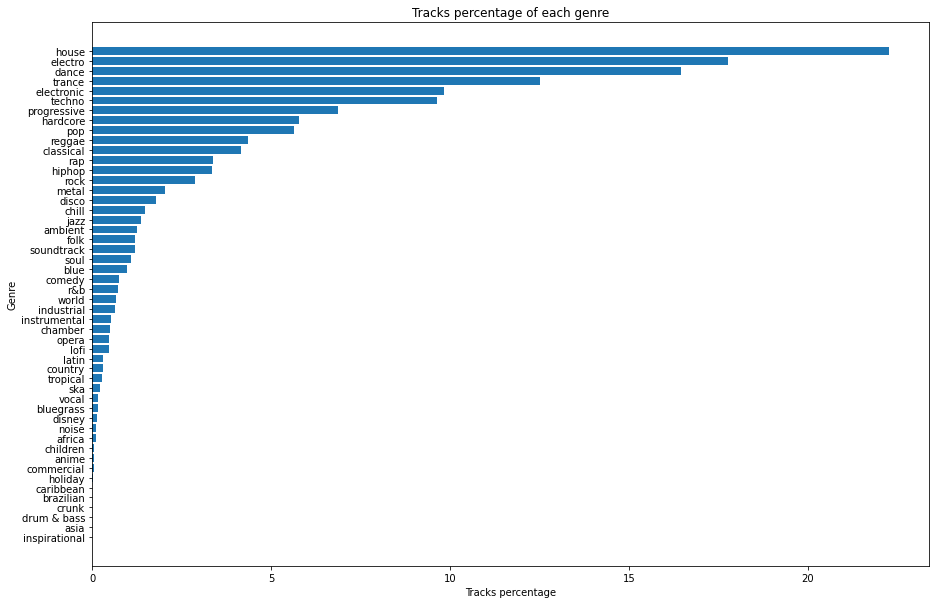

In [52]:
plt.figure(figsize = (15, 10))

plt.title("Tracks percentage of each genre")
plt.ylabel("Genre")
plt.xlabel("Tracks percentage")
tracks_percentage = tracks_percentage.sort_values(ascending = True)
plt.barh(tracks_percentage.index, tracks_percentage)

**Kết quả:** 

Top 3 thể loại phổ biến nhất châu Âu:
1. House
2. Electro
3. Dance

**Kết luận:** Thể loại House là thể loại nhạc phổ biến nhất châu Âu.

## 3. Xét 1 playlist, có mối tương quan nào giữa số lượt thích (`likes_count`) và số lượt chia sẻ (`reposts_count`)? 

- Mục đích: Nếu chúng tương quan dương (cùng tăng - đó là điều ta mong muốn) thì ở 1 số trường hợp, nhiều likes đồng nghĩa với nhiều lượt chia sẻ, như vậy đoạn track đó sẽ được quảng bá tới nhiều người hơn trên SoundCloud 
- Bộ dữ liệu: playlist.csv
- Các bước thực hiện:
    - Vẽ biểu đồ scatter trực quan hóa mối quan hệ giữa số lượt thích và số lượt chia sẻ
    - Tính toán ma trận tương quan (correlation matrix)

### Bước 1: Vẽ biểu đồ scatter trực quan hóa mối quan hệ giữa số lượt thích và số lượt chia sẻ

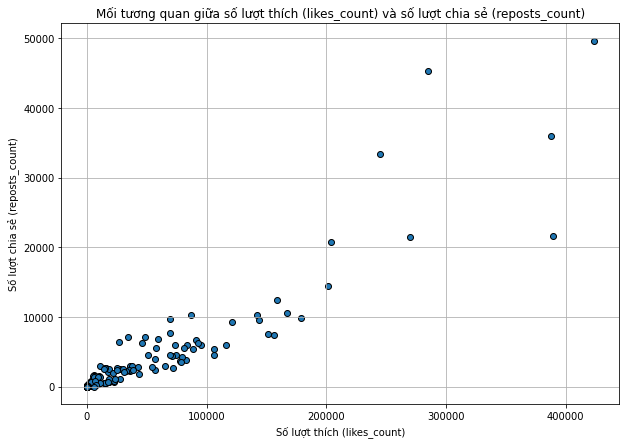

In [58]:
plt.figure(figsize=(10,7))
plt.grid()
plt.scatter(df_playlist['likes_count'], df_playlist['reposts_count'], edgecolors='black')
plt.xlabel('Số lượt thích (likes_count)') 
plt.ylabel('Số lượt chia sẻ (reposts_count)');
plt.title('Mối tương quan giữa số lượt thích (likes_count) và số lượt chia sẻ (reposts_count)');
# plt.axvline(np.mean(df_playlist['likes_count']), color='r', linestyle='--') # lượt like TB

- Nhận xét: Từ quan sát đồ thị tương quan phía dưới, thấy rằng mối quan hệ giữa `số lượt thích` (biến ngẫu nhiên A) và `số lượt chia sẻ` (biến ngẫu nhiên B) gần như là 1 đường tuyến tính. A và B tỷ lệ thuận, tuy nhiên mối quan hệ chỉ thực sự mạnh khi A và B dưới 200.000, còn A và B bắt đầu trên 200.000 thì các điểm dữ liệu thưa thớt dần chứng tỏ mối tương quan càng yếu dần, nghĩa là A và B ngày càng không liên quan tới nhau khi 1 trong 2 biến đạt ít nhất 200.000. Hoặc đơn giản là từ 200.000 trở đi xuất hiện các outliers

### Bước 2: Lập ma trận tương quan
- Để thể hiện sự tương quan giữa A và B bằng 1 con số, ta dùng ma trận tương quan `Pearson correlation matrix`, thấy rằng độ tương quan là ~0.9348

In [ ]:
likes_reposts = df_playlist[['likes_count', 'reposts_count']]
likes_reposts.corr(method = 'pearson')

,likes_count,reposts_count
likes_count,1.000000,0.934814
reposts_count,0.934814,1.000000


- Tuy nhiên, con số ~0.9348 chưa thực sự chính xác vì tương quan Pearson giả định 2 thuộc tính có phân phối chuẩn, trong khi phân phối của thuộc tính `likes_count` không đảm bảo điều đó. 

Text(0.5, 1.0, 'Phân phối của likes_count')

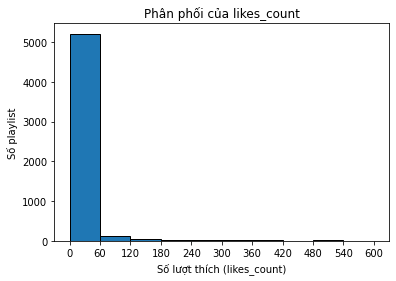

In [ ]:
a = plt.hist(df_playlist['likes_count'], range= (0,600), edgecolor='black')
plt.xticks(a[1])
plt.xlabel('Số lượt thích (likes_count)')
plt.ylabel('Số playlist')
plt.title('Phân phối của likes_count')

- Vì vậy, ta chuyển qua dùng tương quan Spearman, thấy rằng mối tương quan giảm còn ~0.72.

In [ ]:
likes_reposts.corr(method = 'spearman')

,likes_count,reposts_count
likes_count,1.000000,0.721119
reposts_count,0.721119,1.000000


In [95]:
###
a = df_playlist[['likes_count', 'reposts_count']]
q1,q3 = a['likes_count'].quantile([0.25, 0.75])
q0 = q1 - 1.5*(q3-q1)
q4 = q3 + 1.5*(q3-q1)
q0, q4
a = a.loc[(q0 <= a['likes_count']) & (a['likes_count'] <= q4)]

q1,q3 = a['reposts_count'].quantile([0.25, 0.75])
q0 = q1 - 1.5*(q3-q1)
q4 = q3 + 1.5*(q3-q1)
q1,q3

(0.0, 1.0)

## 4. Tương quan giữa likes_count và reposts_count của 1 track
- Câu hỏi quan tâm: 

Text(0, 0.5, 'Số lượt tái chia sẻ (reposts_count)')

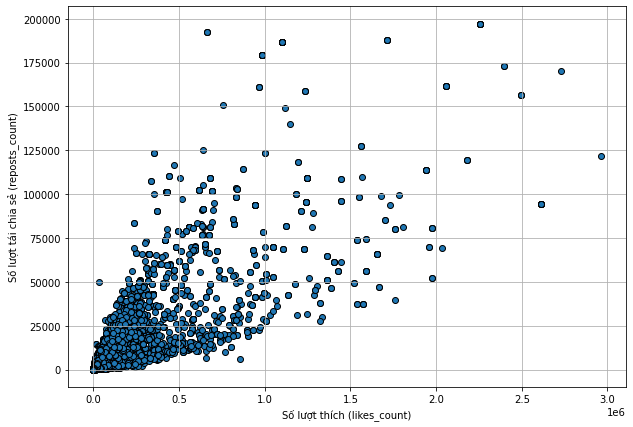

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.scatter(df_track['likes_count'], df_track['reposts_count'], edgecolors='black')
plt.xlabel('Số lượt thích (likes_count)')
plt.ylabel('Số lượt tái chia sẻ (reposts_count)')

In [ ]:
likes_reposts = df_track[['likes_count', 'reposts_count']]
likes_reposts.corr(method = 'spearman')

,likes_count,reposts_count
likes_count,1.000000,0.962842
reposts_count,0.962842,1.000000


## Tương quan giữa followers_count & track_count của 1 verified user
- **Câu hỏi quan tâm**: Liệu ra nhiều track có đồng nghĩa nhiều người theo dõi hơn để từ đó có thể các user đăng tải nhiều track hơn?
- Từ quan sát đồ thị, dễ thấy rằng không có sự tương quan nào giữa số người theo dõi và số track

Text(0, 0.5, 'Số lượng track (track_count)')

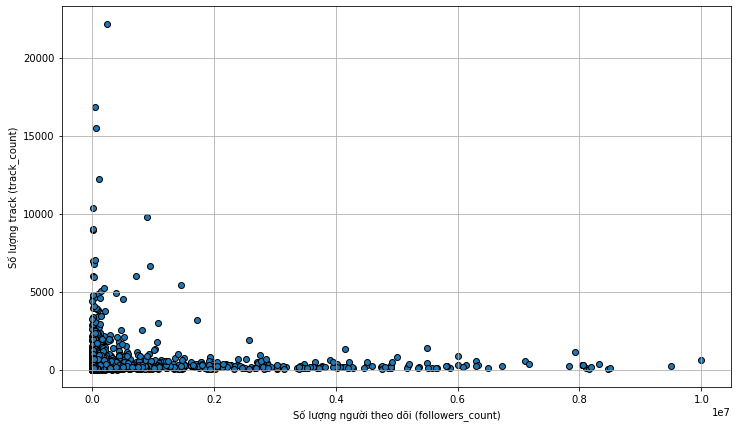

In [ ]:
verified_users = df_user[df_user['verified'] == True]
verified_users

plt.figure(figsize=(12,7))
plt.grid()
plt.scatter(verified_users['followers_count'], verified_users['track_count'], edgecolors='black')
plt.xlabel('Số lượng người theo dõi (followers_count)')
plt.ylabel('Số lượng track (track_count)')

## Mối tương quan giữa likes_count, playback_count, download_count, reposts_count, comment_count

In [ ]:
df = df_track[['likes_count','playback_count','download_count','reposts_count','comment_count']]
df

,likes_count,playback_count,download_count,reposts_count,comment_count
0,104933,3656798,0,1484,2949
1,229321,11713134,0,2994,7358
2,191418,8635832,0,9338,3428
3,84417,2861345,0,952,1064
4,180822,6808317,0,1826,2265
...,...,...,...,...,...
46522,1,299,0,0,0
46529,183990,12199703,0,26231,1319
46530,582,30312,0,78,6
46534,996226,86553052,0,43788,5483


[Text(0.5, 0, 'likes_count'),
 Text(1.5, 0, 'playback_count'),
 Text(2.5, 0, 'download_count'),
 Text(3.5, 0, 'reposts_count'),
 Text(4.5, 0, 'comment_count')]

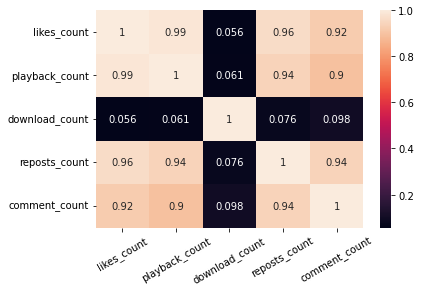

In [ ]:
corr = df.corr(method='spearman')
g = sns.heatmap(corr, annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

- Các biến này có độc lập với nhau không?

## Tần suất ra track (số track/năm) có phụ thuộc (tỉ lệ thuận/nghịch) vào likes_count, playback_count, comment_count
- phụ thuộc: (in)dependent variable?

In [ ]:
# tính cột tần suất
df = df_track[['author_id', 'track_id', 'created_date']]
df['track_id'] = df['track_id'].astype(object)
a = df_user.set_index('user_id').join(df.set_index('author_id'), on='user_id', how='inner')
a = a.loc[a['created_date'].dt.year == 2014]

C:\Users\Admin\AppData\Local\Temp/ipykernel_265280/2270554566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['track_id'] = df['track_id'].astype(object)


In [ ]:
tmp = a.groupby(a.index)[['track_id', 'created_date']]
tmp.agg(track_count = ('track_id','count'),
        date = ('created_date', lambda x: x)).sort_values(by='track_count', ascending=False)
# tmp.first()

,track_count,date
user_id,,
175766,113,"[2014-10-27 10:22:24+00:00, 2014-10-15 07:19:1..."
17478538,32,"[2014-10-04 17:32:20+00:00, 2014-09-30 06:08:0..."
58502729,29,"[2014-01-16 16:07:18+00:00, 2014-09-04 13:39:2..."
1701116,29,"[2014-02-12 02:24:19+00:00, 2014-03-30 18:26:2..."
2185042,27,"[2014-03-20 20:16:44+00:00, 2014-03-20 20:16:4..."
...,...,...
8881740,1,2014-04-30 14:16:11+00:00
8594451,1,2014-07-25 14:00:17+00:00
8539027,1,2014-01-05 21:24:59+00:00
